In [1]:
#imports 

%tensorflow_version 2.x
import tensorflow as tf 
from tensorflow import keras 

#Help-liberies 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#The function takes the train labels and the amount of noise we want to apply 
#The return value is the train_labels with noise 
import random

def adding_noise(labels, percent):
  labels_with_noise = np.zeros((len(labels)))
  for i in range(len(labels)):
    r = random.random()
    if r < percent:
      labels_with_noise[i] = int(labels[i] + 1+ 9*random.random())%10
    else:
      labels_with_noise[i] = labels[i] 
  return labels_with_noise

Creating the Class Model, where modelscan be created, trained and observed


In [3]:


class Model:
      model = keras.Sequential()

      def __init__(self, layers, layersize):

        self.layers = layers
        self.layersize = layersize
        #initializing the model
        self.model = keras.Sequential()
        self.model.add(keras.layers.Flatten(input_shape=(28,28)))#input layer
        for j in range(0, layers):
          self.model.add(keras.layers.Dense(layersize, activation="relu")) #hidden layers
        self.model.add(keras.layers.Dense(10,activation='softmax')) #output layer
        #compile model
        self.model.compile(optimizer= 'adam' , 
                           loss= 'sparse_categorical_crossentropy',metrics=['accuracy'])  
        self.model.count_params()

      '''
      trains the model and returns a List of various data
      data[0] = the train loss after fitting the data 
      data[1] = the train accuracy after fitting the data  
      data[2] = the test loss after evaluating the model 
      data[3] = the test accuracy after evaluating the model  
      '''

      def train(self,epoch,datasize,train_images,train_labels,test_images, test_labels):
        data = np.zeros(4)
        print(datasize,epoch)

        #trainig the model until a certain accuracy is reached
        runs = 0
        train_loss = 100
        train_acc = 0
        e_per_run = 5
        for i in range(epoch):
          history = self.model.fit(train_images[:datasize], train_labels[:datasize],epochs = e_per_run)
          train_loss_all, train_acc_all = history.history.values()
          train_loss = train_loss_all[e_per_run-1]
          train_acc = train_acc_all[e_per_run-1]
          runs = runs + e_per_run
          if train_loss < 0.001:
            break

        test_loss, test_acc = self.model.evaluate(test_images, test_labels, verbose=1)
        data[0] = train_loss
        data[1] = train_acc
        data[2] = test_loss
        data[3] = test_acc
        print(self.model.summary())
        return data

      def getParameter(self):
        return self.model.count_params()



In [4]:
def trainModel(amount,min_layersize,max_layersize, layers, epochs, datasize, noise):
  a = max_layersize - min_layersize 
  data = np.zeros((5,a))

  #load dataset MNIST
  mnist = keras.datasets.mnist
  #spliting into testing and training
  (train_images, train_labels_without_noise), (test_images, test_labels) = mnist.load_data()
  #normalizing data
  train_images = train_images/255.0
  test_images = test_images/255.0
  #adding noise
  train_labels = adding_noise(train_labels_without_noise, noise)

  
  '''
  data[0][i] = the train loss after fitting the data in iterration i (with i layers) 
  data[1][i] = the train accuracy after fitting the data in iterration i (with i layers)  
  data[2][i] = the test loss after evaluating the model in iterration i (with i layers) 
  data[3][i] = the test accuracy after evaluating the model in iterration i (with i layers) 
  data[4][i] = the parameters of the model in iterration i (with i layers)
  '''

  for i in range(0,max_layersize - min_layersize):
    data_help = [0,0,0,0,0]
    for j in range(0,amount):
      print("I an currently in run ",i, " ===> The model has ", i+ min_layersize ,"neurons. ")
      print("amount =", amount) 
      myModel = Model(layers,i + min_layersize)
      history = myModel.train(epochs, datasize,train_images,train_labels,test_images, test_labels)
      param   = myModel.getParameter()
      data_help[0] = data_help[0] + history[0] 
      data_help[1] = data_help[1] + history[1]
      data_help[2] = data_help[2] + history[2]
      data_help[3] = data_help[3] + history[3]
      data_help[4] = data_help[4] + param

    #maby filtering runs, that went wrong
    data[0][i] = data_help[0]/amount
    data[1][i] = data_help[1]/amount
    data[2][i] = data_help[2]/amount
    data[3][i] = data_help[3]/amount
    data[4][i] = data_help[4]
  return data 

in the next block, i want to creata a example curve of the double descent

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
313/313 [==============================] - 1s 4ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 5/5
313/313 [==============================] - 1s 4ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 1/5
313/313 [==============================] - 1s 4ms/step - loss: 0.0200 - accuracy: 0.9936
Epoch 2/5
313/313 [==============================] - 1s 4ms/step - loss: 0.0065 - accuracy: 0.9988
Epoch 3/5
313/313 [==============================] - 1s 4ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 4/5
313/313 [==============================] - 1s 4ms/step - loss: 9.6827e-04 - accuracy: 1.0000
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.2630 - accuracy: 0.9511
Model: "sequential_267"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_266 (Flatten)       (None, 784)               0         
                        

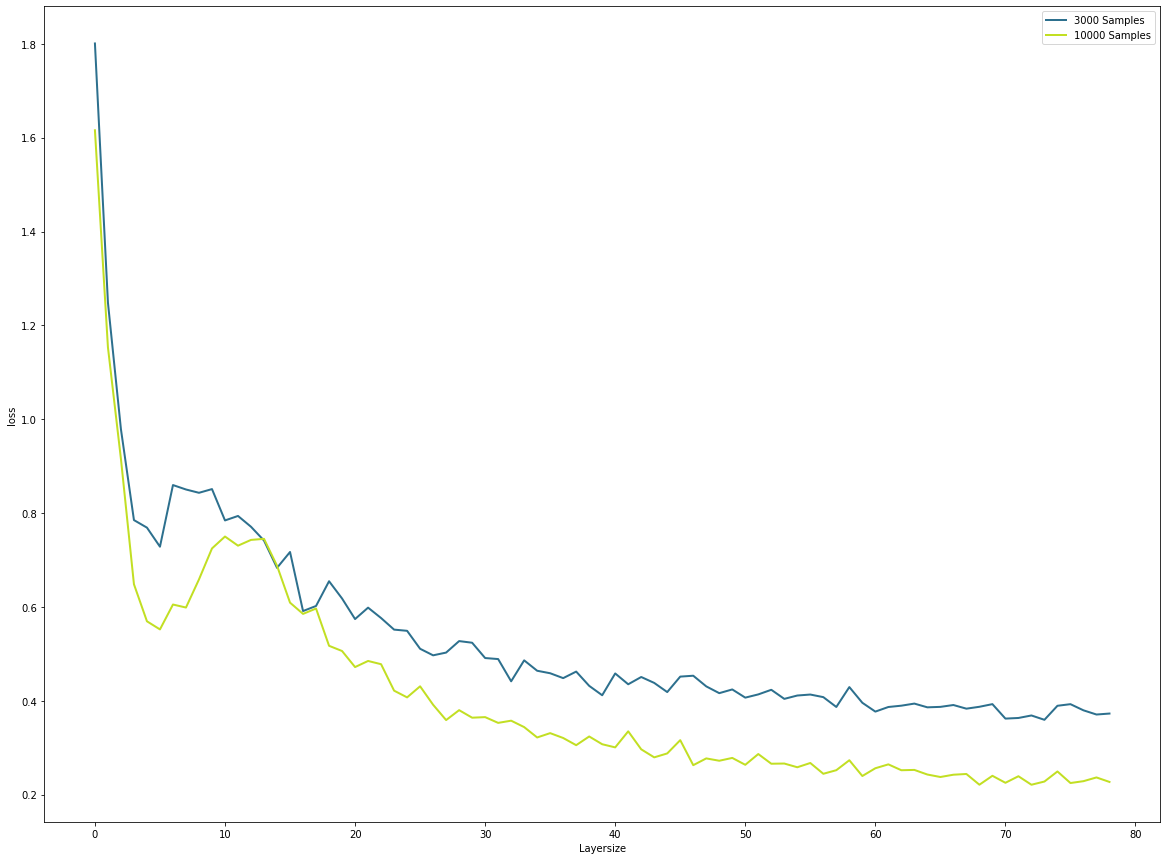

In [6]:

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm

def plot_risk_with_data(amount):
  data = []
  for i in range(len(amount)):
    data_help = (trainModel(4,1,50,1,200,amount[i], 0))
    data.append(data_help)
 
  viridis = cm.get_cmap('viridis', 12)
  colors = [viridis(x) for x in np.linspace(0.4,0.9,len(data))]

  fig, ax = plt.subplots(1)
  fig.set_size_inches(20,15)
  for i in range(len(data)):
    ax.plot(data[i][2],linewidth=2.0, color = colors[i], label = str(amount[i]) + " Samples") 
    #ax.plot(data[i][0],linewidth=2.0, color = colors[i]) 

  ax.set_xlabel('Layersize')
  ax.set_ylabel('loss')  
  ax.legend(loc='upper right')
  plt.savefig("more_is_less")


amount = [4000,15000]
plot_risk_with_data(amount)

